# Predicting a loan's success in kiva's crowdfinding platform
## Human-Agent interaction final project
### By Einat Heletz and Eyal Golan

# Table of Contents
1. [Introduction](#intro)
2. [Preprocessing](#preprocessing)
3. [Analyzing the data](#analyzing)
4. [Final results](#results)
4. [Conclusions](#conclusions)

# <a class="anchor" id="intro">1. Introduction</a>
<b>What is Kiva?</b><br>
Kiva is a non-profit organization that allows people to lend money via the Internet to low-income entrepreneurs and
students in 77 countries.
Kiva's mission is "to expand financial access to help underserved communities thrive."
Since 2005, Kiva has crowd-funded more than 1.6 million loans, totaling over $1.33 billion, with a repayment rate of 
95.8 percent. Over 1.8 million lenders worldwide use the Kiva platform. Lenders do not receive interest on the money 
they lend. Kiva includes personal stories of each person who applies for a loan so that lenders can connect with 
borrowers on a human level.<br>
<br><br>
<b>Motivation</b><br>
The Kiva platform is used to extend financial services to poor and financially excluded people around the world.
It's lenders have provided over billions of dollars in loans to millions of people.
In order to inform lenders, set investment priorities and understand the lenders target communities -
knowing the poverty level of each borrower is important.
However, this requires inference based on limited information for each borrower.
<br><br>
<b>Our goal</b><br>
As part of out final project in the Human-Agent interaction course, our goal is to determine which factors come to play
in a lender's decision to provide a load or not - Which factors give a lender the security he or she needs that they
will get the money back? which people do lenders tend to trust? why?

## 1.1 Data
[Data Science for Good: Kiva Crowdfunding](https://www.kaggle.com/kiva/data-science-for-good-kiva-crowdfunding)

Explaining the data:
Kiva Crowdfunding - we use the following kiva_loans.csv dataset. The dataset contains the following fields:
   * id	- int, the id number of the loan request
   * funded_amount - The amount disbursed by Kiva to the field agent(USD)
   * loan_amount - The amount disbursed by the field agent to the borrower(USD)
   * activity - The activity for which the load is requested
   * sector - The category of the activity
   * use - The purpose of the load
   * country_code - ISO country code of country in which loan was disbursed
   * country - Full country name of country in which loan was disbursed
   * region - Full region name within the country
   * currency - The currency in which the loan was disbursed
   * partner_id - Unique ID for field partners
   * posted_time
   * disbursed_time
   * funded_time
   * term_in_months
   * lender_count
   * tags - Additional information about the load, for example: #Woman Owned Biz, #Parent, #First Loan
   * borrower_genders - the gender of each of the borrowers

# <a class="anchor" id="preprocessing">2. Preprocessing</a>

## 2.1 Loading the data

In [1]:
import pandas as pd
import numpy as np
import math
import nltk
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm
import warnings
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime

In [2]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tqdm.pandas()

print("Loading the datasets ...")
loans = pd.read_csv(r"datasets/kiva_loans.csv")
print("Loaded all the datasets")

Loading the datasets ...
Loaded all the datasets


## 2.2 Labeling loans by Successful/Unsuccessful

We will classify the loans into 2 categories - 
1. Successful - A loan which has been fully funded by Kiva lender.
2. Unsuccessful - A partially funded loan.
<br>

The label will be based on the following condition:<br>
loan_amount - funded_amount == 0

unsuccessful loans: 48328, successful loans: 622875


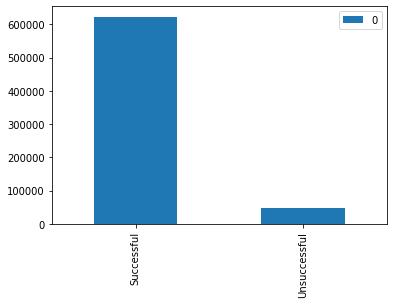

In [3]:
unsuccessful_loans_df = loans[loans['funded_amount'] < loans['loan_amount']]
successful_loans_df = loans[loans['funded_amount'] == loans['loan_amount']]
print(f'unsuccessful loans: {len(unsuccessful_loans_df)}, successful loans: {len(successful_loans_df)}')

ax = pd.DataFrame([len(successful_loans_df), len(unsuccessful_loans_df)], index=["Successful", "Unsuccessful"]).plot(kind="bar")

In [4]:
successful_loans_df.loc[:,'Key'] = 'Successful'
unsuccessful_loans_df.loc[:,'Key'] = 'Unsuccessful'
loans_with_label = pd.concat([successful_loans_df, unsuccessful_loans_df]).reset_index(drop=True)

C:\Users\eyalg\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\eyalg\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


#  <a class="anchor" id="analyzing">3. Analyzing the data</a>
We will take fields from different columns and generate features from them. Some examples:
1. Tags - some interesting tags can produce a boolean feature (exists or not)
2. "is_funded" (boolean) - loan_amount - funded_amount == 0

## 3.1 Gender Features
We will extract 3 features: amount of borrowers, the existence of a feminine and the existence of a masculine.<br>
In case of missing value in the borrower_genders field, the values are defined as follows, correspondingly: 0, False, False.

In [5]:
loans_with_label['borrowers_amount'] = loans_with_label.apply(lambda r:len(r.borrower_genders.split(',')) if type(r.borrower_genders) is str else 0, axis=1)
loans_with_label['has_female'] = loans_with_label.apply(lambda r:'female' in r.borrower_genders.split(',') if type(r.borrower_genders) is str else False, axis=1)
loans_with_label['has_male'] = loans_with_label.apply(lambda r:'male' in r.borrower_genders.split(',') if type(r.borrower_genders) is str else False, axis=1)

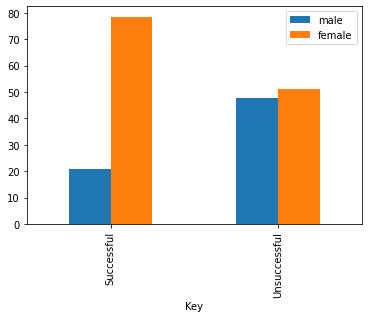

In [6]:
males_count = loans_with_label.groupby(['Key', 'has_male']).size().unstack('has_male')[True]
females_count = loans_with_label.groupby(['Key', 'has_female']).size().unstack('has_female')[True]
gender_df = pd.DataFrame([males_count, females_count], index=['male', 'female'])
gender_df["Successful"] = gender_df["Successful"].apply(lambda x: x / len(successful_loans_df) * 100)
gender_df["Unsuccessful"] = gender_df["Unsuccessful"].apply(lambda x: x / len(unsuccessful_loans_df) * 100)
ax = gender_df.transpose().plot(kind="bar")

#### Results
This barplot shows the percentage of loans with male and female borrowers in successful and unsuccessful loans separately

## 3.2 Extracting the loan's use
The use column contains free text for the lenders to describe the purpose of their loan.


First we will take a quick look at the data using wordcloud to get the general idea for the usage of the loans, and
what the lenders need the money for.


And then we'll extract some features from the text.


### Exploring
The use columns is a free text that describes the purpose of the loan, using a wordcloud can give the essence of
successful and unsuccessful loans.

In [7]:
nltk.download('stopwords')

stop_words = set(nltk.corpus.stopwords.words('english')) 
tokenizer = RegexpTokenizer(r'\w+')
final = []
for use in successful_loans_df.use:
    if type(use) != str:
        continue
    tokenized = tokenizer.tokenize(use)
    filtered = [w.lower() for w in tokenized if w not in stop_words]
    final.extend(filtered)
final_successful = " ".join(final)

stop_words = set(nltk.corpus.stopwords.words('english')) 
tokenizer = RegexpTokenizer(r'\w+')
final = []
for use in unsuccessful_loans_df.use:
    if type(use) != str:
        continue
    tokenized = tokenizer.tokenize(use)
    filtered = [w.lower() for w in tokenized if w not in stop_words]
    final.extend(filtered)
final_unsuccessful = " ".join(final)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eyalg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
word_cloud = WordCloud(width = 800, height = 800,
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(final_successful)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(word_cloud)
plt.axis("off") 
plt.tight_layout(pad = 0) 

print("Word cloud for successful loans")

plt.show() 

Word cloud for unsuccessful loans


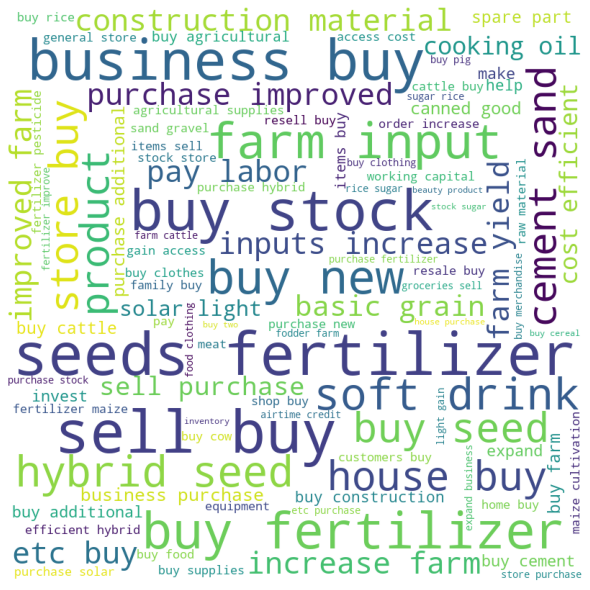

In [9]:
word_cloud = WordCloud(width = 800, height = 800,
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(final_unsuccessful)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(word_cloud)
plt.axis("off") 
plt.tight_layout(pad = 0) 

print("Word cloud for unsuccessful loans")

plt.show()

### Results

Viewing the word clouds we can see that the words such as "water", "safe drinking", "water filter" are used in
successful loans, whereas "buy", "sell", "soft drink" and "business" are used more in unsuccessful loans.

### Extracting Lexical Diversity, Text Length, Word Count and TF/IDF
We will extract 4 features: Lexical Diversity, Text Length, Word Count and TF/IDF.

#### Filling missing data
We fill the missing data in order to avoid errors

In [10]:
def fill_missing_values(field, value):
    missing_values_before = loans_with_label[field].apply(lambda x: 1 if type(x) is float and math.isnan(x) else 0).sum()
    loans_with_label[field] = loans_with_label[field].fillna(value)
    missing_values_after = loans_with_label[field].apply(lambda x: 1 if type(x) is float and math.isnan(x) else 0).sum()
    print(f'Missing values in {field} - before: {missing_values_before}, after: {missing_values_after}')

fill_missing_values('partner_id', 0)
fill_missing_values('lender_count', 0)
fill_missing_values('country_code', 'na')
fill_missing_values('use', '')

Missing values in partner_id - before: 13507, after: 0
Missing values in lender_count - before: 0, after: 0
Missing values in country_code - before: 8, after: 0
Missing values in use - before: 4232, after: 0


#### Checking the effect of each feature
We want to check how the 4 feature - Lexical Diversity, Text Length, Word Count and TF/IDF - effect the choice of the
borrower.

#### lexical diversity and word count
we check the effect of the loan's use field lexical diversity and the number of words in the use field -
on the borrowers.

In [11]:
nltk.download('punkt')

unique_words = dict()
def lexical_diversity(text):
    tokenized_text = nltk.word_tokenize(text)
    if len(tokenized_text) == 0:
        return 0
    for i in tokenized_text:
        try:
            unique_words[i] += 1
        except Exception as e:
            unique_words[i] = 1
    return len(set(tokenized_text)) / len(tokenized_text)

loans_with_label['lexical_diversity'] = loans_with_label['use'].progress_apply(lexical_diversity)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eyalg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 671203/671203 [01:18<00:00, 8502.31it/s] 


In [12]:
loans_with_label['use_length'] = loans_with_label['use'].apply(lambda x: len(x))
loans_with_label['word_count'] = loans_with_label['use'].progress_apply(lambda x: len(nltk.word_tokenize(x)))

100%|██████████| 671203/671203 [01:14<00:00, 8974.04it/s] 


#### TF-IDF
TF-IDF stands for “Term Frequency — Inverse Document Frequency”.
This is a technique to quantify a word in documents,
we generally compute a weight to each word which signifies the importance of the word in the document and corpus.


In our case, we check the effect of each word in the "use" field - on the borrowers.

In [13]:
filtered_use = loans['use'].apply(lambda x: x if not pd.isna(x) else "")

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(filtered_use)

# get the first vector out (for the first document)
first_vector_tfidfvectorizer = tfidf_vectorizer_vectors[0]

# place tf-idf values in a pandas data frame
temp_df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
tfidf_df = temp_df.sort_values(by=["tfidf"],ascending=False)

In [14]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
def tfidf_extraction(use):
    values = []
    for i in tokenizer.tokenize(use):
        i = i.lower()
        if i not in tfidf_df.index:
            continue
        values.append(tfidf_df.loc[i].iloc[0])
    return np.array(values).max(initial=0)

loans_with_label['tfidf'] = loans_with_label['use'].progress_apply(tfidf_extraction)

100%|██████████| 671203/671203 [09:12<00:00, 1215.18it/s]


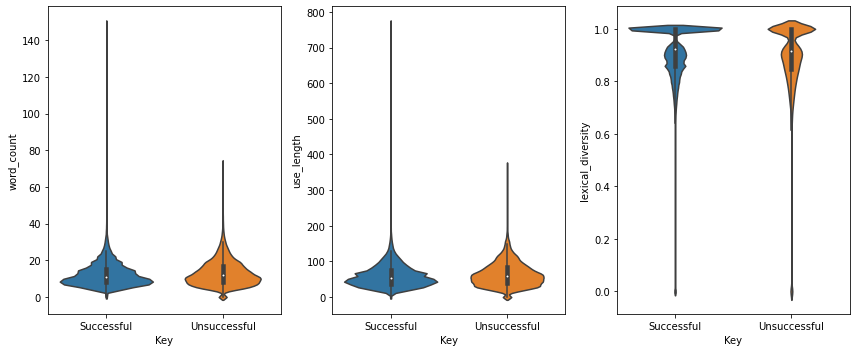

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
ax = sns.violinplot(x="Key", y="word_count", data=loans_with_label, ax=axes[0])
ax = sns.violinplot(x="Key", y="use_length", data=loans_with_label, ax=axes[1])
ax = sns.violinplot(x="Key", y="lexical_diversity", data=loans_with_label, ax=axes[2])

plt.tight_layout()
plt.show()

# todo add more here and understand what tal wrote
#### Results
After analyzing the plots, it seems that the successful loans have a shorter but richer sentence in the use field.

## 3.3 Extracting the posted date
The dataset has 3 different date columns. Posted, funded and disbursed. <br>
- Funded time is not usable because has 100% correlation with our label (If a fund hasn't been fully funded,
it won't have funded time)
- Disbursed time column has too many missing entries.
- Posted time is the only useful column, so we'll be using it for our features.

We add 4 numeric features (day, month, year, day in the week)

In [16]:
def time_to_feature(date_):
    date_ = datetime.strptime(date_, "%Y-%m-%d %H:%M:%S+00:00")
    return pd.Series({"posted_year": date_.year, "posted_month": date_.month, "posted_day": date_.day, "posted_weekday": date_.weekday(), "posted_hour": date_.hour})

posted_time_series = loans_with_label['posted_time'].progress_apply(time_to_feature)

100%|██████████| 671203/671203 [03:01<00:00, 3700.71it/s]


In [17]:
loans_with_label = loans_with_label.merge(posted_time_series, left_index=True, right_index=True)

## 3.4 Tags
The tags column contains one cell for each loan entry.
This single cell might contain more than one tag, in order to use this data we'll have to create a feature for each
different tag that exists in dataset set. <br>
The tags column might be useful, so we will have to preprocess it.<br>
This section adds tags as independent columns. It takes a while to compute.

### 3.4.1 Tags preprocessing

In [18]:
def get_tag_list(tags):
    stags = set()
    if type(tags) != str:
        return set()
    tags = tags.split(",")
    for tag in tags:
        tag = tag.strip("# '")
        stags.add(tag)
    return stags

all_tags = set()
for tags in loans.tags:
    all_tags.update(get_tag_list(tags))
print(f'Total tags obtained: {len(all_tags)}')

loans_with_label['tag_list'] = loans_with_label.apply(lambda r: get_tag_list(r['tags']), axis=1)

Total tags obtained: 35


### 3.4.2 Tags extraction
Adding each tag as a feature

In [19]:
for tag in tqdm(all_tags):
    loans_with_label[f'{tag}_tag'] = loans_with_label.apply(lambda r: tag in r['tag_list'], axis=1)
    

100%|██████████| 35/35 [03:11<00:00,  5.48s/it]


### 3.4.3 Tags selection

Processing the effect of the tags on the loan's success

In [20]:
tag_names = [tag + '_tag' for tag in all_tags]
tags_df = pd.DataFrame(index=tag_names, columns =['successful', 'unsuccessful'])
appearance_tags_df = pd.DataFrame(columns =['successful', 'unsuccessful'])
successful_with_tags = loans_with_label.query("Key == 'Successful'")
unsuccessful_with_tags = loans_with_label.query("Key == 'Unsuccessful'")
for tag in tag_names:    
    sudf_num = int(successful_with_tags[successful_with_tags[tag] == 1].count().iloc[0] / successful_with_tags.count().iloc[0] * 100)
    undf_num = int(unsuccessful_with_tags[unsuccessful_with_tags[tag] == 1].count().iloc[0] / unsuccessful_with_tags.count().iloc[0] * 100)
    tags_df.loc[tag] = [sudf_num, undf_num]
    if sudf_num != 0 or undf_num != 0:
        appearance_tags_df.loc[tag] = [sudf_num, undf_num]


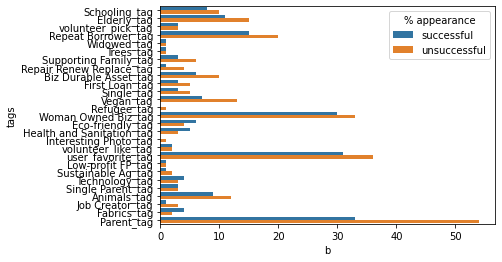

In [21]:
appearance_tags_df.index.name = 'tags'
tags_df_melted = appearance_tags_df.reset_index().melt(var_name='% appearance', value_name='b', id_vars=['tags'])
ax = sns.barplot(y='tags', x='b', hue='% appearance', data=tags_df_melted)

#### Results

Looking at the results - it seems that the tags: Technology, Fabrics, Eco-Friendly, Health and Sanitation are the top
 tags for successful loans. However, the Refugee and Interesting photo tags were always in unsuccessful loans.

using only 'user_favorite' tag

In [22]:
tags_selected = ['user_favorite_tag']

### 3.5.1 Loan amount by sector

Here we get an impression of which loan sectors are more likely to be funded.

<AxesSubplot:xlabel='sector'>

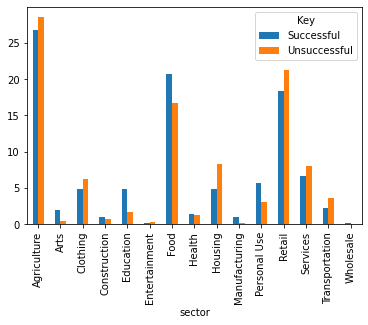

In [23]:
sectors = loans.sector.unique()

sector_loans_df = loans_with_label.groupby(["sector", "Key"]).size().unstack("Key")
sector_loans_df["Successful"] = sector_loans_df["Successful"].apply(lambda x: x / len(successful_loans_df) * 100)
sector_loans_df["Unsuccessful"] = sector_loans_df["Unsuccessful"].apply(lambda x: x / len(unsuccessful_loans_df) * 100)
sector_loans_df.plot(kind="bar")

#### Results

The ratios seem to be even among successful and unsuccessful loans, but some field seem to be more likely to be more
successful (Personal use, Education and food).

#### 3.5.2 Loan amount by sector

Let's look at average loan amount per sector of successful and unsuccessful loans:

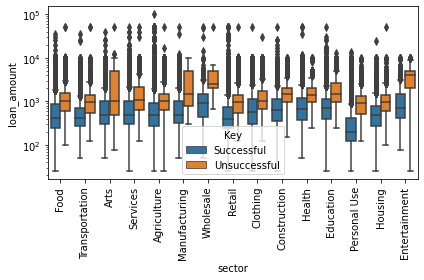

In [24]:
ax = sns.boxplot(x="sector", y="loan_amount", data=loans_with_label, hue="Key")
ax.set_yscale("log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

#### Results

For each sector, the average loan amount is greater on unsuccessful loans.

We can also see which sector requests for higher loans, and what is the average request that succeeds (for each sector).

#### 3.5.3 Loan amount

Let's look at the average loan amount of successful and unsuccessful loans:

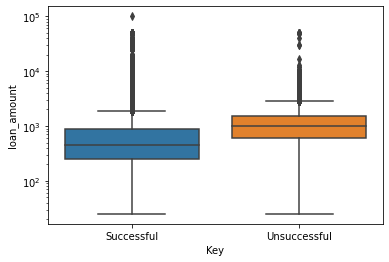

In [25]:
ax = sns.boxplot(x="Key", y="loan_amount", data=loans_with_label)
ax.set_yscale('log')
plt.show()

#### Results

On average, unsuccessful loans request higher amounts.

### 3.5.4 Term in months

Let's look at the term in months of successful and unsuccessful loans:

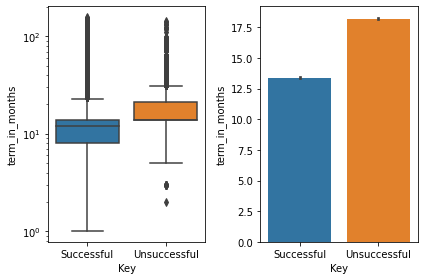

In [26]:
plt.subplot(1, 2, 1)
ax = sns.boxplot(x="Key", y="term_in_months", data=loans_with_label)
ax.set_yscale('log')
plt.subplot(1, 2, 2)
ax = sns.barplot(x="Key", y="term_in_months", data=loans_with_label)

plt.tight_layout()
plt.show()

#### Results

We can see here that on average, unsuccessful loans request for a longer term to return the loans.

#### 3.5.5 Repayment interval

Let's look at the repayment interval of successful and unsuccessful loans:

<AxesSubplot:xlabel='repayment_interval'>

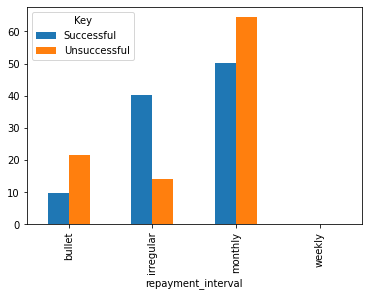

In [27]:
repayment_intervals = loans_with_label.repayment_interval.unique()


loans_by_repayment = loans_with_label.groupby(["Key", "repayment_interval"]).size().unstack("Key")
loans_by_repayment["Successful"] = loans_by_repayment["Successful"].apply(lambda x: x / len(successful_loans_df) * 100)
loans_by_repayment["Unsuccessful"] = loans_by_repayment["Unsuccessful"].apply(lambda x: x / len(unsuccessful_loans_df) * 100)
loans_by_repayment.plot(kind="bar")

#### Results

Most of the unsuccessful loans have monthly repayment interval, while almost 50% of the successful loans have irregular
interval.

It seems a bit odd, since borrowers might prefer a safer repayment method, but this is probably a classic
case of causation != correlation. There's probably a different cause for this diff on the interval rate, but
nevertheless it can be a useful feature.

# <a class="anchor" id="results">4. Final results</a>

Let's summarize the results:

* There is a visible connection between the gender and the success of the loan - There were allot more successful loans
by females than by males - by a large margin. Also, looking at unsuccessful loans - there is a balance between the number of
unsuccessful loans by males and females

* words such as "water", "safe drinking", "water filter" are used in
successful loans, whereas "buy", "sell", "soft drink" and "business" are used more in unsuccessful loans.

* Successful loans have a shorter but richer sentence in the use field.

* The tags: Technology, Fabrics, Eco-Friendly, Health and Sanitation are the top
 tags for successful loans. However, the Refugee and Interesting photo tags were always in unsuccessful loans.

The ratios seem to be even among successful and unsuccessful loans, but some field seem to be more likely to be more
successful (Personal use, Education and food).

* For each sector, the average loan amount is greater on unsuccessful loans.

* On average, unsuccessful loans request higher amounts.

* On average, unsuccessful loans request for a longer term to return the loans.

* Most of the unsuccessful loans have monthly repayment interval, while almost 50% of the successful loans have irregular
interval.

It seems a bit odd, since borrowers might prefer a safer repayment method, but this is probably a classic
case of causation != correlation. There's probably a different cause for this diff on the interval rate, but
nevertheless it can be a useful feature.


# <a class="anchor" id="conclusions">5. Conclusions</a>